In [1]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "svg"

# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting, residual_calc02
from my_progs.catalog.pos_diff import nor_sep_calc, pos_diff_calc
from my_progs.catalog.pos_err import pos_err_calc
from my_progs.catalog.write_output import print_vsh1_corr, print_vsh2_corr

In [2]:
# Read ICRF3 S/X catalog
icrf3_sx = Table.read("../data/icrf3sx.txt",
                      format="ascii.fixed_width", data_start=16,
                      names=["icrf_name", "iers_name_sx", "type_sx",
                             "ra_err_sx", "dec_err_sx", "ra_dec_corr_sx",
                             "mean_obs_sx", "beg_obs_sx", "end_obs_sx", "nb_sess_sx", "nb_del_sx"],
                      col_starts=[5, 25, 35, 83, 98,
                                  108, 118, 127, 136, 145, 150],
                      col_ends=[20, 32, 35, 92, 106, 114, 124, 133, 142, 148, 155])

# Position information
ra_dec = Table.read("../data/icrf3sx.txt",
                    format="ascii.fixed_width", data_start=16,
                    names=["ra_dec"], col_starts=[40], col_ends=[77])

ra_dec_sx = SkyCoord(ra_dec["ra_dec"], unit=(u.hourangle, u.deg))
ra_sx = Column(ra_dec_sx.ra, name="ra_sx")
dec_sx = Column(ra_dec_sx.dec, name="dec_sx")

# Add source position to the table
icrf3_sx.add_columns([ra_sx, dec_sx], indexes=[3, 3])

# Add unit information
icrf3_sx["ra_err_sx"] = icrf3_sx["ra_err_sx"] * 15e3 * np.cos(ra_dec_sx.dec.rad)
icrf3_sx["ra_err_sx"].unit = u.mas
icrf3_sx["dec_err_sx"].unit = u.arcsec
icrf3_sx["dec_err_sx"] = icrf3_sx["dec_err_sx"].to(u.mas)

# Calculate the semi-major axis of error ellipse
pos_err_sx = pos_err_calc(icrf3_sx["ra_err_sx"], icrf3_sx["dec_err_sx"], icrf3_sx["ra_dec_corr_sx"])

# Add the semi-major axis of error ellipse to the table
icrf3_sx.add_column(pos_err_sx, name="pos_err_sx", index=9)


In [3]:
# Read ICRF3 K catalog
icrf3_k = Table.read("../data/icrf3k.txt",
                      format="ascii.fixed_width", data_start=16,
                      names=["icrf_name", "iers_name_k", "type_k",
                             "ra_err_k", "dec_err_k", "ra_dec_corr_k",
                             "mean_obs_k", "beg_obs_k", "end_obs_k", "nb_sess_k", "nb_del_k"],
                      col_starts=[5, 25, 35, 83, 98,
                                  108, 118, 127, 136, 145, 150],
                      col_ends=[20, 32, 35, 92, 106, 114, 124, 133, 142, 148, 155])

# Position information
ra_dec = Table.read("../data/icrf3k.txt",
                    format="ascii.fixed_width", data_start=16,
                    names=["ra_dec"], col_starts=[40], col_ends=[77])

ra_dec_k = SkyCoord(ra_dec["ra_dec"], unit=(u.hourangle, u.deg))
ra_k = Column(ra_dec_k.ra, name="ra_k")
dec_k = Column(ra_dec_k.dec, name="dec_k")

# Add source position to the table
icrf3_k.add_columns([ra_k, dec_k], indexes=[3, 3])

# Add unit information
icrf3_k["ra_err_k"] = icrf3_k["ra_err_k"] * 15e3 * np.cos(ra_dec_k.dec.rad)
icrf3_k["ra_err_k"].unit = u.mas
icrf3_k["dec_err_k"].unit = u.arcsec
icrf3_k["dec_err_k"] = icrf3_k["dec_err_k"].to(u.mas)

# Calculate the semi-major axis of error ellipse
pos_err_k = pos_err_calc(icrf3_k["ra_err_k"], icrf3_k["dec_err_k"], icrf3_k["ra_dec_corr_k"])

# Add the semi-major axis of error ellipse to the table
icrf3_k.add_column(pos_err_k, name="pos_err_k", index=9)
icrf3_k["pos_err_k"].unit = u.mas


In [4]:
# Crossmatch.
sx_k_com = join(icrf3_sx, icrf3_k, keys="icrf_name") 

In [5]:
coord_sx_com = SkyCoord(ra=sx_k_com["ra_sx"], dec=sx_k_com["dec_sx"], frame="icrs")
coord_k_com = SkyCoord(ra=sx_k_com["ra_k"], dec=sx_k_com["dec_k"], frame="icrs")
dra, ddec = coord_sx_com.spherical_offsets_to(coord_k_com)

There are 793 common sources between S/X and K catalogs.

In [6]:
# The positional offset for common sources between S/X and K (K - SX).
[dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov,
 ang_sep, X_a, X_d, X] = pos_diff_calc(
    sx_k_com["ra_k"], sx_k_com["ra_err_k"], sx_k_com["dec_k"], sx_k_com["dec_err_k"], sx_k_com["ra_dec_corr_k"],
    sx_k_com["ra_sx"], sx_k_com["ra_err_sx"], sx_k_com["dec_sx"], sx_k_com["dec_err_sx"], sx_k_com["ra_dec_corr_sx"])

sx_k_com.add_columns([dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d, X],
                     names=["dra", "ddec", "dra_err", "ddec_err", "dra_ddec_cov",
                           "ang_sep", "nor_dra",  "nor_ddec", "nor_sep_cov"])

sx_k_com["dra"].unit = u.mas
sx_k_com["ddec"].unit = u.mas
sx_k_com["dra_err"].unit = u.mas

sx_k_com

<Table masked=True length=793>
   icrf_name     iers_name_sx ...       nor_ddec           nor_sep_cov    
                              ...         deg                  deg        
     str16           str8     ...       float64              float64      
---------------- ------------ ... -------------------- -------------------
J000435.6-473619     0002-478 ...  0.48316524664027555   1.188197792634294
J000504.3+542824     0002+541 ...  -0.4241320949828758   0.570766021761459
J000557.1+382015     0003+380 ...  0.22664239066719688  0.8985118393643539
J000613.8-062335     0003-066 ...  -3.4858018726344424   4.187109670844749
J000903.9+062821     0006+061 ...  -1.4922597077016488  1.6869373615767118
J001031.0+105829     0007+106 ...   0.8262234716191628  0.8634038326324605
J001101.2-261233     0008-264 ...    1.241063341456311  1.3272867837539675
J001135.2+082355     0009+081 ...    1.098418436292494  1.1379891608036476
J001259.9-395426     0010-401 ...   -2.454031141496655  2.4670233483872845
             ...          ... ...                  ...                 ...
J234719.8-511036     2344-514 ...   0.8315214562255626  1.1326942032358946
J234831.7+062459     2345+061 ...  -0.1144716809395715 0.31007667713216086
J234920.8+384917     2346+385 ...  -0.3583774187713677  1.4276261050734633
J235421.6+455304     2351+456 ...  0.21466970772033656  2.8000288401253473
J235430.1-151311     2351-154 ...   0.2647130231763808  1.6639817378996609
J235622.7+815252     2353+816 ...   0.9517204676238995  1.6681494760028974
J235725.1-015215     2354-021 ...  -1.4526262775946275  1.6136299900714344
J235753.2-531113     2355-534 ...   0.2815224497379852  1.5777219545726495
J235810.8-102008     2355-106 ...   1.4109100751077075  1.5899278810034219
J235935.4-313343     2357-318 ... -0.40139674081844173  1.5636750970050717

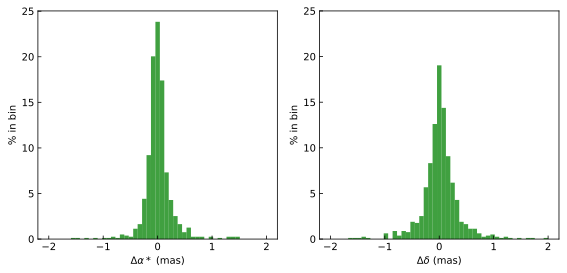

In [7]:
# Difference in RA and decl.
bins_array = np.linspace(-2, 2, 50)
weights = np.ones_like(dRA) * 100. / dRA.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dRA, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(dDC, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 30, 5))
ax1.set_yticks(np.arange(0, 30, 5))

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

In [8]:
std_ra = np.std(X_a)
std_dec = np.std(X_d)

std_ra, std_dec

(2.0322947552772006, 5.13772220709775)

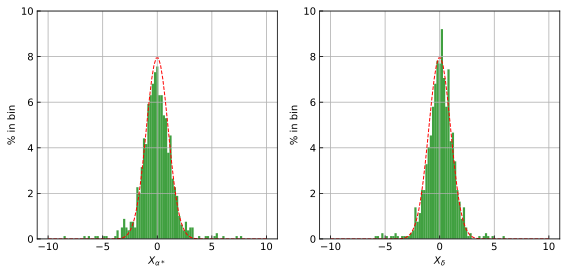

In [9]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(X_a, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(X_d, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

ax0.grid()
ax1.grid()

fig.tight_layout()
# plt.show()

plt.savefig("../plots/icrf3_sx_k_nor_off.png")

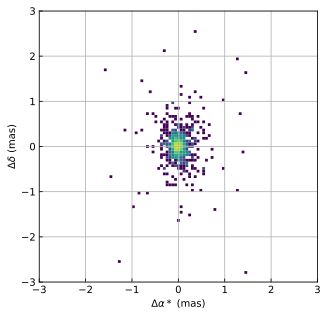

In [10]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(5, 5))

bins = np.linspace(-3, 3, 100)

# We can increase the number of bins on each axis
ax.hist2d(dRA, dDC, bins, norm=colors.LogNorm())

ax.set_xlabel("$\Delta\\alpha*$ (mas)")
ax.set_ylabel("$\Delta\\delta$ (mas)")

ax.grid(True)

plt.show()

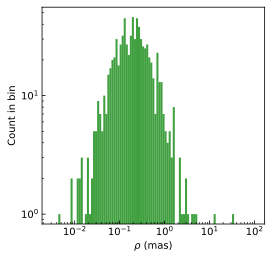

In [11]:
# Distribution of angular separation
bins_array = 10 ** np.linspace(-2.5, 2, 100)
# bins_array = np.linspace(-2, 2, 50)

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(ang_sep, bins_array, facecolor="g", alpha=0.75)

ax.set_xlabel("$\\rho$ (mas)")
ax.set_ylabel("Count in bin")

ax.set_xscale("log")
ax.set_yscale("log")

plt.show()

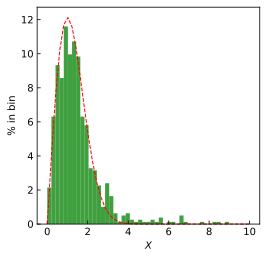

In [12]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X) * 100. / X.size

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(X, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlabel("$X$")
ax.set_ylabel("% in bin")

plt.show()

In [13]:
# Divide sources into 'Defining'  and 'Others'
mask = (sx_k_com["type_sx"] == "D")
sx_k_com_def = sx_k_com[mask]

mask = (sx_k_com["type_sx"] != "D")
sx_k_com_oth = sx_k_com[mask]

sx_k_com_def, sx_k_com_oth

(<Table masked=True length=193>
    icrf_name     iers_name_sx ...       nor_ddec           nor_sep_cov    
                               ...         deg                  deg        
      str16           str8     ...       float64              float64      
 ---------------- ------------ ... -------------------- -------------------
 J000435.6-473619     0002-478 ...  0.48316524664027555   1.188197792634294
 J001031.0+105829     0007+106 ...   0.8262234716191628  0.8634038326324605
 J001611.0-001512     0013-005 ...   2.1607362980051823  2.7404566084229067
 J001937.8+202145     0017+200 ... -0.03805383374673815 0.07046439980380508
 J001945.7+732730     0016+731 ... -0.16434752964099142   0.227594103009174
 J003814.7-245902     0035-252 ...  -0.6706927427095454   2.895530280998233
 J004847.1+315725     0046+316 ...    2.105269021448535  2.3275073767695185
 J004943.2+023703     0047+023 ...  -0.9471986710579268  1.0936962015155667
 J005041.3-092905     0048-097 ...   0.5932713045337735 

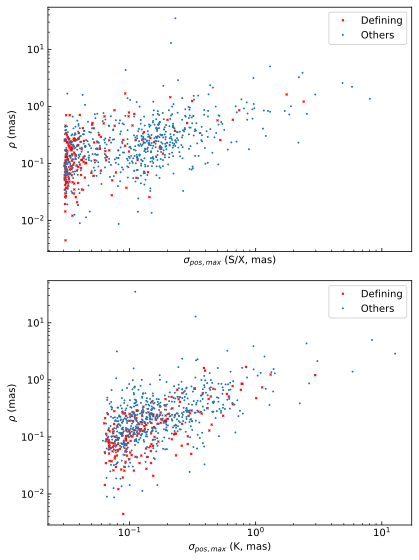

In [14]:
# Angular position difference vs. positional uncertainty
fig, (ax0, ax1) = plt.subplots(figsize=(6, 8), nrows=2, sharex=True)

ax0.plot(sx_k_com_def["pos_err_sx"],
         sx_k_com_def["ang_sep"], "rx", ms=2, label="Defining")
ax1.plot(sx_k_com_def["pos_err_k"],
         sx_k_com_def["ang_sep"], "rx", ms=2, label="Defining")

ax0.plot(sx_k_com_oth["pos_err_sx"],
         sx_k_com_oth["ang_sep"], ".", ms=2, label="Others")
ax1.plot(sx_k_com_oth["pos_err_k"],
         sx_k_com_oth["ang_sep"], ".", ms=2, label="Others")

ax0.set_xscale("log")
ax0.set_yscale("log")
ax1.set_xscale("log")
ax1.set_yscale("log")

ax0.set_xlabel("$\sigma_{pos,max}$ (S/X, mas)")
ax0.set_ylabel("$\\rho$ (mas)")
ax1.set_xlabel("$\sigma_{pos,max}$ (K, mas)")
ax1.set_ylabel("$\\rho$ (mas)")


ax0.legend()
ax1.legend()

fig.tight_layout()
plt.show()

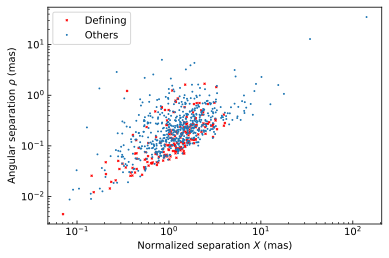

In [15]:
# Angular separation vs. Normalized separation
fig, ax = plt.subplots()
# figsize=(6, 8)

ax.plot(sx_k_com_def["nor_sep_cov"],
         sx_k_com_def["ang_sep"], "rx", ms=2, label="Defining")
ax.plot(sx_k_com_oth["nor_sep_cov"],
         sx_k_com_oth["ang_sep"], ".", ms=2, label="Others")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Normalized separation $X$ (mas)")
ax.set_ylabel("Angular separation $\\rho$ (mas)")

ax.legend()

plt.show()

In [16]:
# Remove the outlier (do not consider the normalized separation)
mask = ((sx_k_com["ang_sep"] < 100) & 
        (sx_k_com["pos_err_sx"] < 100) & 
        (sx_k_com["pos_err_k"] < 100))

# Table of a clean sample
sx_k_clean = sx_k_com[mask]

# print("After elimination, there are %d sources in the clean sample" % len(sx_k_clean))

In [17]:
# Transform column into np.array
dra1 = np.array(sx_k_clean["dra"])
ddec1 = np.array(sx_k_clean["ddec"])
dra_err1 = np.array(sx_k_clean["dra_err"])
ddec_err1 = np.array(sx_k_clean["ddec_err"])
ra_rad1 = np.array(sx_k_clean["ra_sx"].to(u.radian))
dec_rad1 = np.array(sx_k_clean["dec_sx"].to(u.radian))
dra_ddec_cov1 = np.array(sx_k_clean["dra_ddec_cov"])

In [18]:
# Transformation parameters
# l_max = 1
w1_all, sig1_all, corrcoef1_all = vsh_deg01_fitting(
    dra1, ddec1, ra_rad1, dec_rad1, dra_err1, ddec_err1, 
    cov=dra_ddec_cov1, elim_flag="None")

# l_max = 2
w2_all, sig2_all, corrcoef2_all = vsh_deg02_fitting(
    dra1, ddec1, ra_rad1, dec_rad1, dra_err1, ddec_err1, 
    cov=dra_ddec_cov1, elim_flag="None")

# mas -> uas
w1 = w1_all * 1.e3
sig1 = sig1_all * 1.e3
w2 = w2_all * 1.e3
sig2 = sig2_all * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra1.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_all, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_all, deci_digit=1, included_one=False)

Estimates (   793 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1   -22 +/-  24   -33 +/-  24    +1 +/-  14     +13 +/-  18   +30 +/-  18   +25 +/-  24
l_max=2   -15 +/-  30   -17 +/-  29    +8 +/-  15     -17 +/-  25   +51 +/-  26   +26 +/-  28
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       -2    10
            EI22       -3    10
            ER21      -34    29
            EI21      -71    30
             E20        7    33
            MR22        2    15
            MI22      -11    15
            MR21       15    30
     

In [19]:
# Remove the outlier (consider the normalized separation)
N = len(sx_k_com)
X0 = np.sqrt(np.log(N) * 2)

print("There are %d sources.\n"
      "When X >= %.2f, the number of the outlier is smaller than 1." % (N, X0))

mask = ((sx_k_com["nor_sep_cov"] <= X0)
        & (sx_k_com["ang_sep"] < 10)
        & (sx_k_com["pos_err_sx"] < 10)
        & (sx_k_com["pos_err_k"] < 10))

# Table of a clean sample
sx_k_clean = sx_k_com[mask]

print("After elimination, there are %d sources in the clean sample" % len(sx_k_clean))

There are 793 sources.
When X >= 3.65, the number of the outlier is smaller than 1.
After elimination, there are 752 sources in the clean sample


In [20]:
# Transform column into np.array
dra2 = np.array(sx_k_clean["dra"])
ddec2 = np.array(sx_k_clean["ddec"])
dra_err2 = np.array(sx_k_clean["dra_err"])
ddec_err2 = np.array(sx_k_clean["ddec_err"])
ra_rad2 = np.array(sx_k_clean["ra_sx"].to(u.radian))
dec_rad2 = np.array(sx_k_clean["dec_sx"].to(u.radian))
dra_ddec_cov2 = np.array(sx_k_clean["dra_ddec_cov"])

In [21]:
# Transformation parameters
# l_max = 1
w1_cln, sig1_cln, corrcoef1_cln = vsh_deg01_fitting(
    dra2, ddec2, ra_rad2, dec_rad2, dra_err2, ddec_err2,
    cov=dra_ddec_cov2, elim_flag="None")

# l_max = 2
w2_cln, sig2_cln, corrcoef2_cln = vsh_deg02_fitting(
    dra2, ddec2, ra_rad2, dec_rad2, dra_err2, ddec_err2,
    cov=dra_ddec_cov2, elim_flag="None")

# mas -> uas
w1 = w1_cln * 1.e3
sig1 = sig1_cln * 1.e3
w2 = w2_cln * 1.e3
sig2 = sig2_cln * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra2.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_cln, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_cln, deci_digit=1, included_one=False)

Estimates (   752 sources)
--------------------------------------------------------------------------------------------
               Rotation [uas]                                   Glide [uas]               
               x             y             z               x             y             z
--------------------------------------------------------------------------------------------
l_max=1   -11 +/-   7   -18 +/-   6    -7 +/-   4     +15 +/-   5   +20 +/-   5   +18 +/-   7
l_max=2    +3 +/-   8    -7 +/-   7    -2 +/-   4      -7 +/-   7   +39 +/-   7   +27 +/-   7
--------------------------------------------------------------------------------------------

Quadrupolar term Estimate Error
---------------- -------- -----
            ER22       -7     3
            EI22       -8     3
            ER21      -22     8
            EI21      -47     8
             E20      -15     9
            MR22       11     4
            MI22       -3     4
            MR21       20     8
     

In [22]:
# Remove the systematics
RA = np.array(sx_k_com["ra_sx"].to(u.radian))
DE = np.array(sx_k_com["dec_sx"].to(u.radian))

# dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_all)
dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_cln)

In [23]:
# Now re-calculate the normalized difference
ang_sep_ns, Xa_ns, Xd_ns, X_ns = nor_sep_calc(
    dra_ns, dRA_err, ddec_ns, dDC_err, dRA_dDC_cov/dRA_err/dDC_err)

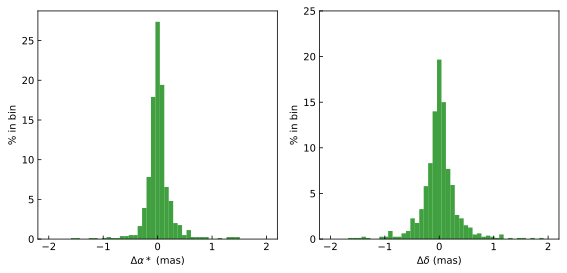

In [24]:
# Difference in RA and decl.
bins_array = np.linspace(-2, 2, 50)
weights = np.ones_like(dra_ns) * 100. / dra_ns.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dra_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(ddec_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 30, 5))
ax1.set_yticks(np.arange(0, 30, 5))

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

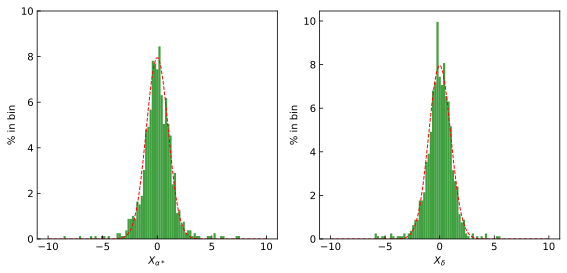

In [25]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(Xa_ns) * 100. / Xa_ns.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(Xa_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(Xd_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

fig.tight_layout()
plt.show()

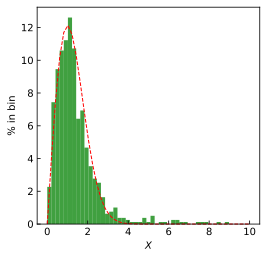

In [26]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X_ns) * 100. / X_ns.size

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(X_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlabel("$X$")
ax.set_ylabel("% in bin")

plt.show()

The last step is to save the 16 transformation parameters for further use.

In [27]:
# The 16-parameter estimated using all the sample
vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2_all*1e3, sig2_all*1e3], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf3_sx_k_vsh02_all.log", format="ascii", overwrite=True)

# The 16-parameter estimated using a clean sample
vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf3_sx_k_vsh02.log", format="ascii", overwrite=True)